In [14]:
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Aim of this code: Building an equivariant autoencdoer which is equivariant under horizontal shifts over MNIST.

In [8]:
#Constructing the permutation matrix P, and the realization basis Q.

first_row = np.zeros(28)
first_row[-1] = 1

circulant_matrix = np.zeros((28, 28))

for i in range(28):
    circulant_matrix[i, :] = np.roll(first_row, i)

block_diagonal_matrix = block_diag(*[circulant_matrix] * 28)

eigenvalues = np.linalg.eigvals(block_diagonal_matrix)


n = 28
def circulant_eigenvectors(n):
    dft_matrix = np.fft.fft(np.eye(n))
    eigenvectors = np.conjugate(dft_matrix.T)
    return eigenvectors


eigenvectors = circulant_eigenvectors(n)

def new_basis(eigenvectors):
    n = eigenvectors.shape[0]
    new_basis_vectors = np.zeros_like(eigenvectors, dtype=np.complex128)

    for j in range(1, n // 2 ):
        factor = 1 / ( np.sqrt(2*n))
        new_basis_vectors[:, 2*j-1] = (eigenvectors[:, j] + eigenvectors[:, -j]) * factor
        new_basis_vectors[:, 2*j] = (eigenvectors[:, j] - eigenvectors[:, -j]) * (-1j * factor)

    if n % 2 == 0:
        j = n // 2
        new_basis_vectors[:, -1] = (eigenvectors[:, j] + eigenvectors[:, -j]) / (2*np.sqrt(n))

    return new_basis_vectors


new_basis_vectors = new_basis(eigenvectors)
new_basis_vectors[:,0]= eigenvectors[:,0]/np.sqrt(n)

n_squared = n ** 2

matrix = np.zeros((n_squared, n_squared),dtype=np.complex128)

for i in range(n):
    matrix[i*n:i*n+n, i] = new_basis_vectors[:,0]
for j in range(13):    
    for i in range(n):
        matrix[i*n:i*n+n,2*i+n*(2*j+1)] = new_basis_vectors[:,2*j+1]
        matrix[i*n:i*n+n,2*i+n*(2*j+1)+1] = new_basis_vectors[:,2*j+2]
    
for i in range(n):
    matrix[i*n:i*n+n, n*(n-1)+i ] = new_basis_vectors[:,n-1]




In [9]:
# Load MNIST dataset
mnist = fetch_openml("mnist_784")
X, y = mnist.data.astype('float32'), mnist.target.astype('int')
X, y = shuffle(X, y, random_state=42)

In [15]:
#Training a linear autoencoder with handwritten images (shifted up to 20 percent shifts )
# Load MNIST dataset
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
datagen = ImageDataGenerator(height_shift_range=0.2, fill_mode='nearest')
x_train_shifted = []
for img in x_train:
    batch = img.reshape((1,) + img.shape)
    for batch_shifted in datagen.flow(batch, batch_size=1):
        x_train_shifted.append(batch_shifted[0, :, :, 0])
        break

x_train_shifted = np.array(x_train_shifted)
x_test_shifted = []
for img in x_test:
    batch = img.reshape((1,) + img.shape)
    for batch_shifted in datagen.flow(batch, batch_size=1):
        x_test_shifted.append(batch_shifted[0, :, :, 0])
        break

x_test_shifted = np.array(x_test_shifted)

# Flatten images
x_train_shifted_flat = x_train_shifted.reshape((len(x_train_shifted), np.prod(x_train_shifted.shape[1:])))
x_test_shifted_flat = x_test_shifted.reshape((len(x_test_shifted), np.prod(x_test_shifted.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the linear autoencoder model with rank set 99
input_img = Input(shape=(784,))
encoded = Dense(99, activation='linear', use_bias=False)(input_img)
decoded = Dense(784, activation='linear', use_bias=False)(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder with the shifted dataset
autoencoder.fit(x_train_shifted_flat, x_train_shifted_flat, epochs=15, batch_size=256, shuffle=True, validation_data=(x_test_shifted_flat, x_test_shifted_flat))

# Encode and decode 10 random digits from the test set
np.random.seed(44)
random_indices = np.random.choice(x_test_shifted_flat.shape[0], 10, replace=False)
encoded_imgs = autoencoder.predict(x_test_shifted_flat[random_indices])


Epoch 1/15
235/235 [==============================] - 3s 10ms/step - loss: 0.0317 - val_loss: 0.0129
Epoch 2/15
235/235 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0082
Epoch 3/15
235/235 [==============================] - 2s 10ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 4/15
235/235 [==============================] - 2s 10ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 5/15
235/235 [==============================] - 2s 10ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 6/15
235/235 [==============================] - 2s 10ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 7/15
235/235 [==============================] - 3s 11ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 8/15
235/235 [==============================] - 2s 10ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 9/15
235/235 [==============================] - 2s 10ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 10/15
235/235 [==============================] - 2s 10ms/step - loss: 0.0060 - val_los

Encoder Weight Matrix Shape: (784, 99)
Decoder Weight Matrix Shape: (99, 784)


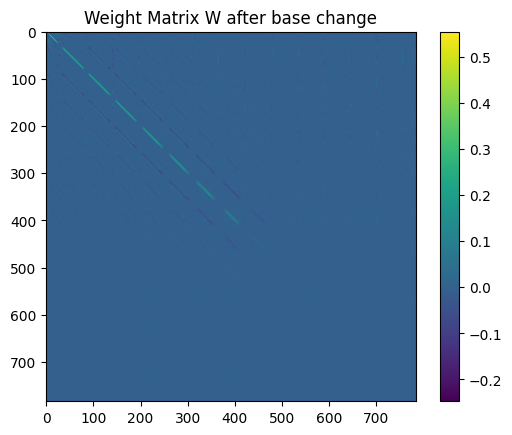

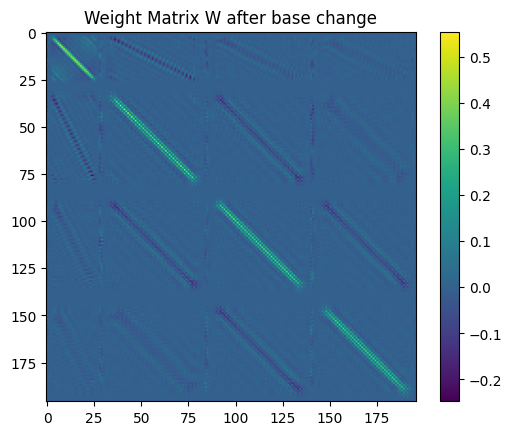

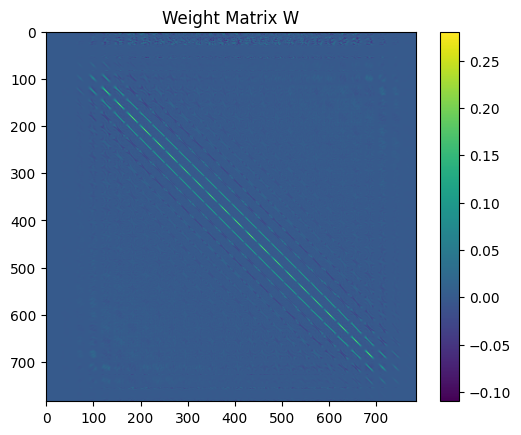

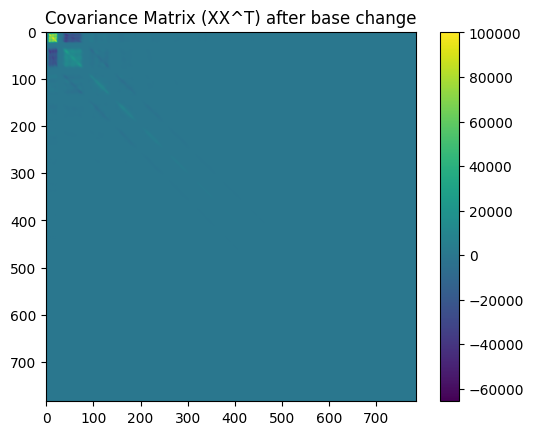

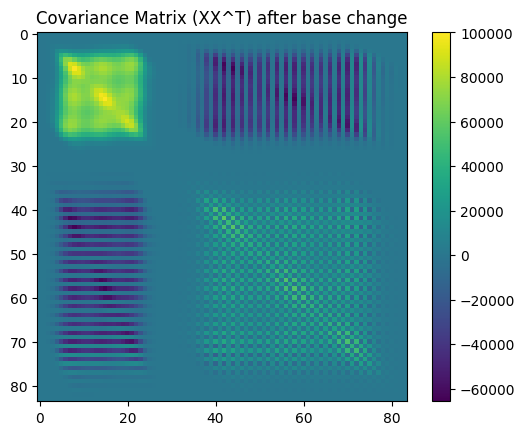

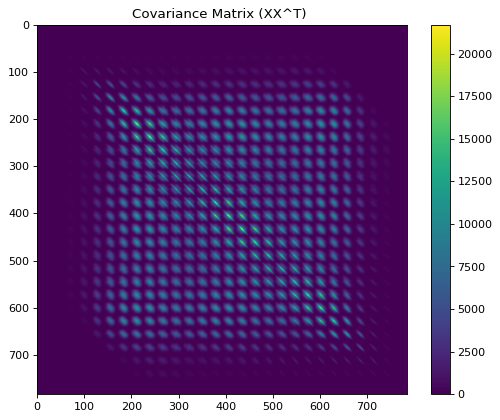

In [16]:
Q = matrix.real
# Get the weights of the first Dense layer (encoder)
encoder_weights = autoencoder.layers[1].get_weights()[0]
# Get the weights of the second Dense layer (decoder)
decoder_weights = autoencoder.layers[2].get_weights()[0]

# Display the shape of the weight matrices
print("Encoder Weight Matrix Shape:", encoder_weights.shape)
print("Decoder Weight Matrix Shape:", decoder_weights.shape)
WWs1 = encoder_weights @ decoder_weights
Ws1 = Q.T @ WWs1.T @ Q

plt.imshow(Ws1[0:,0:], cmap='viridis')
plt.title('Weight Matrix W after base change')
plt.colorbar()
plt.show()

plt.imshow(Ws1[0:196,0:196], cmap='viridis')
plt.title('Weight Matrix W after base change')
plt.colorbar()
plt.show()

plt.imshow(WWs1[0:,0:], cmap='viridis')
plt.title('Weight Matrix W')
plt.colorbar()
plt.show()



RR = x_train_shifted_flat.T @ x_train_shifted_flat
RR1 = Q.T @  RR.T@ Q
#print(np.linalg.matrix_rank(RR))

plt.imshow(RR1[0:,0:], cmap='viridis')
plt.title('Covariance Matrix (XX^T) after base change')
plt.colorbar()
plt.show()
plt.imshow(RR1[0:84,0:84], cmap='viridis')
plt.title('Covariance Matrix (XX^T) after base change')
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(RR, cmap='viridis')
plt.title('Covariance Matrix (XX^T) ')
plt.colorbar()
plt.show()


In [17]:
DD = x_train_shifted_flat @ Q

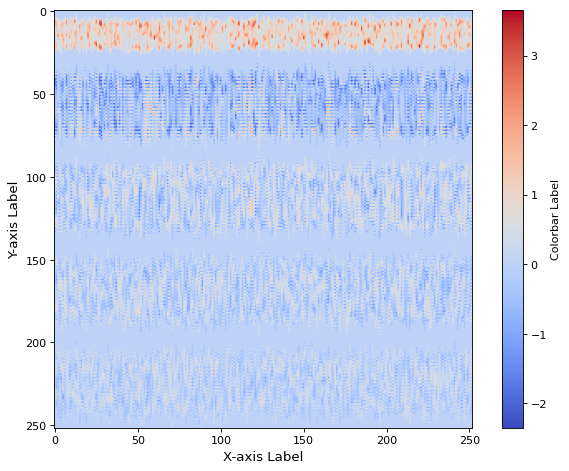

In [18]:
#Applying the base change for flatten data X
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(DD.T[0:252,0:252], cmap='coolwarm')  
plt.colorbar(label='Colorbar Label') 
plt.xlabel('X-axis Label', fontsize=12)  
plt.ylabel('Y-axis Label', fontsize=12) 
plt.tight_layout()  
plt.show()

0.0055974503
0.008753752
0.011730541
0.0023339975
0.0015165815
0.005365878
0.0063181603
0.009829802
0.00651537
0.007688071


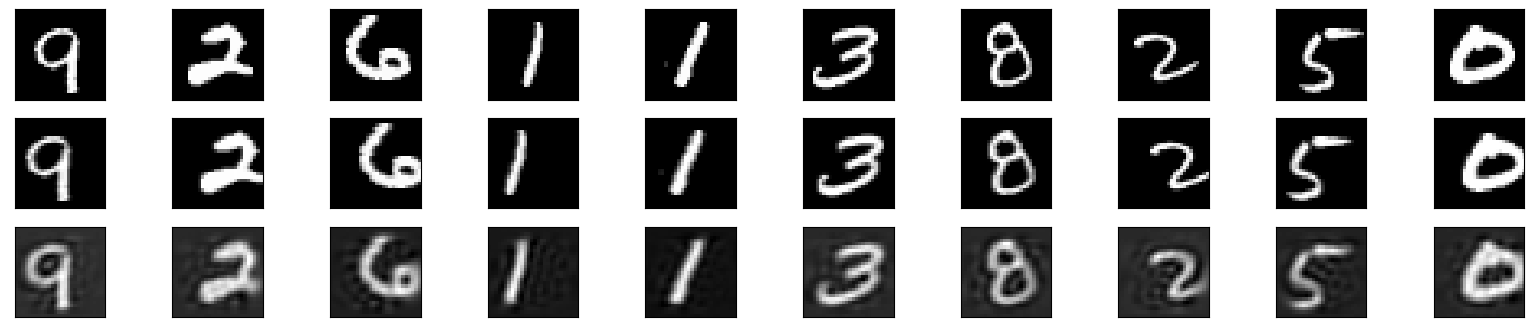

In [19]:
#Output of trained linear autoencoder
plt.figure(figsize=(20, 4))
for i, index in enumerate(random_indices):
    
    ax = plt.subplot(3, 10, i + 1)
    
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(x_test_shifted_flat[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(index)
    ax = plt.subplot(3, 10, i + 21)
    
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #error
    print(np.mean(np.square(x_test_shifted_flat[index]-encoded_imgs[i])))
plt.show()



In [20]:
xtr_tot = DD
xte_tot = x_test_shifted_flat@Q

In [21]:
#Training a semi equivariant (realization format has not been imposed) autoencoder over 15 blocks. Different rank can be applied for each components.

xtr = xtr_tot[:,0:28]
xte = xte_tot[:,0:28]


input_img = Input(shape=(28,))
encoded = Dense(13, activation='linear', use_bias=False)(input_img)
decoded = Dense(28, activation='linear', use_bias=False)(encoded)
autoencoder0 = Model(input_img, decoded)
autoencoder0.compile(optimizer='adam', loss='mean_squared_error')
autoencoder0.fit(xtr, xtr, epochs=45, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs0 = autoencoder0.predict(xte[random_indices])
#####################################################################################
#"for loop" is not used for blocks 1 to 13 because one might need to adjust the paramters for training indiviual blocks e.g., epochs and etc.
rank = 20
block_num = 1 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder1 = Model(input_img, decoded)
autoencoder1.compile(optimizer='adam', loss='mean_squared_error')
autoencoder1.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs1 = autoencoder1.predict(xte[random_indices])
#####################################################################################
rank = 18
block_num = 2 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder2 = Model(input_img, decoded)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs2 = autoencoder2.predict(xte[random_indices])
#####################################################################################
rank = 16
block_num = 3 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder3 = Model(input_img, decoded)
autoencoder3.compile(optimizer='adam', loss='mean_squared_error')
autoencoder3.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs3 = autoencoder3.predict(xte[random_indices])
#####################################################################################
rank = 14
block_num = 4
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder4 = Model(input_img, decoded)
autoencoder4.compile(optimizer='adam', loss='mean_squared_error')
autoencoder4.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs4 = autoencoder4.predict(xte[random_indices])
#####################################################################################
rank = 10
block_num = 5 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder5 = Model(input_img, decoded)
autoencoder5.compile(optimizer='adam', loss='mean_squared_error')
autoencoder5.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs5 = autoencoder5.predict(xte[random_indices])
#####################################################################################
rank = 6
block_num = 6
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder6 = Model(input_img, decoded)
autoencoder6.compile(optimizer='adam', loss='mean_squared_error')
autoencoder6.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs6 = autoencoder6.predict(xte[random_indices])
####################################################################################
rank = 2
block_num = 7 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder7 = Model(input_img, decoded)
autoencoder7.compile(optimizer='adam', loss='mean_squared_error')
autoencoder7.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs7 = autoencoder7.predict(xte[random_indices])
#####################################################################################
rank = 0
block_num = 8 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder8 = Model(input_img, decoded)
autoencoder8.compile(optimizer='adam', loss='mean_squared_error')
autoencoder8.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs8 = autoencoder8.predict(xte[random_indices])
#####################################################################################
rank = 0
block_num = 9 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
# Define the autoencoder model
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder9 = Model(input_img, decoded)
autoencoder9.compile(optimizer='adam', loss='mean_squared_error')
autoencoder9.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs9 = autoencoder9.predict(xte[random_indices])
#####################################################################################
rank = 0
block_num = 10 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder10 = Model(input_img, decoded)
autoencoder10.compile(optimizer='adam', loss='mean_squared_error')
autoencoder10.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs10 = autoencoder10.predict(xte[random_indices])
#####################################################################################
rank = 0
block_num = 11 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder11 = Model(input_img, decoded)
autoencoder11.compile(optimizer='adam', loss='mean_squared_error')
autoencoder11.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs11 = autoencoder11.predict(xte[random_indices])
#####################################################################################
rank = 0
block_num = 12 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder12 = Model(input_img, decoded)
autoencoder12.compile(optimizer='adam', loss='mean_squared_error')
autoencoder12.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs12 = autoencoder12.predict(xte[random_indices])
#####################################################################################
rank = 0
block_num = 13 
xtr = xtr_tot[:,28+56*(block_num-1):28+56*(block_num)]
xte = xte_tot[:,28+56*(block_num-1):28+56*(block_num)]
input_img = Input(shape=(56,))
encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
decoded = Dense(56, activation='linear', use_bias=False)(encoded)
autoencoder13 = Model(input_img, decoded)
autoencoder13.compile(optimizer='adam', loss='mean_squared_error')
autoencoder13.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs13 = autoencoder13.predict(xte[random_indices])
#########################################################################
xtr = xtr_tot[:,756:]
xte = xte_tot[:,756:]
input_img = Input(shape=(28,))
encoded = Dense(0, activation='linear', use_bias=False)(input_img)
decoded = Dense(28, activation='linear', use_bias=False)(encoded)
autoencoder14 = Model(input_img, decoded)
autoencoder14.compile(optimizer='adam', loss='mean_squared_error')
autoencoder14.fit(xtr, xtr, epochs=25, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs14 = autoencoder14.predict(xte[random_indices])

Epoch 1/45
235/235 [==============================] - 1s 4ms/step - loss: 0.4795 - val_loss: 0.1693
Epoch 2/45
235/235 [==============================] - 1s 3ms/step - loss: 0.1248 - val_loss: 0.0845
Epoch 3/45
235/235 [==============================] - 1s 3ms/step - loss: 0.0637 - val_loss: 0.0458
Epoch 4/45
235/235 [==============================] - 1s 3ms/step - loss: 0.0388 - val_loss: 0.0311
Epoch 5/45
235/235 [==============================] - 1s 4ms/step - loss: 0.0283 - val_loss: 0.0240
Epoch 6/45
235/235 [==============================] - 1s 4ms/step - loss: 0.0227 - val_loss: 0.0198
Epoch 7/45
235/235 [==============================] - 1s 4ms/step - loss: 0.0192 - val_loss: 0.0169
Epoch 8/45
235/235 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0147
Epoch 9/45
235/235 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0129
Epoch 10/45
235/235 [==============================] - 1s 3ms/step - loss: 0.0129 - val_loss: 0.0115

In [22]:
#Constructing each block for the trained semi-equivariant linear autoencoder
encoder_weights0 = autoencoder0.layers[1].get_weights()[0]
decoder_weights0 = autoencoder0.layers[2].get_weights()[0]
WW0 = encoder_weights0 @ decoder_weights0

encoder_weights1 = autoencoder1.layers[1].get_weights()[0]
decoder_weights1 = autoencoder1.layers[2].get_weights()[0]
WW1 = encoder_weights1 @ decoder_weights1

encoder_weights2 = autoencoder2.layers[1].get_weights()[0]
decoder_weights2 = autoencoder2.layers[2].get_weights()[0]
WW2 = encoder_weights2 @ decoder_weights2

encoder_weights3 = autoencoder3.layers[1].get_weights()[0]
decoder_weights3 = autoencoder3.layers[2].get_weights()[0]
WW3 = encoder_weights3 @ decoder_weights3

encoder_weights4 = autoencoder4.layers[1].get_weights()[0]
decoder_weights4 = autoencoder4.layers[2].get_weights()[0]
WW4 = encoder_weights4 @ decoder_weights4

encoder_weights5 = autoencoder5.layers[1].get_weights()[0]
decoder_weights5 = autoencoder5.layers[2].get_weights()[0]
WW5 = encoder_weights5 @ decoder_weights5

encoder_weights6 = autoencoder6.layers[1].get_weights()[0]
decoder_weights6 = autoencoder6.layers[2].get_weights()[0]
WW6 = encoder_weights6 @ decoder_weights6

encoder_weights7 = autoencoder7.layers[1].get_weights()[0]
decoder_weights7 = autoencoder7.layers[2].get_weights()[0]
WW7 = encoder_weights7 @ decoder_weights7

encoder_weights8 = autoencoder8.layers[1].get_weights()[0]
decoder_weights8 = autoencoder8.layers[2].get_weights()[0]
WW8 = encoder_weights8 @ decoder_weights8

encoder_weights9 = autoencoder9.layers[1].get_weights()[0]
decoder_weights9 = autoencoder9.layers[2].get_weights()[0]
WW9 = encoder_weights9 @ decoder_weights9

encoder_weights10 = autoencoder10.layers[1].get_weights()[0]
decoder_weights10 = autoencoder10.layers[2].get_weights()[0]
WW10 = encoder_weights10 @ decoder_weights10

encoder_weights11 = autoencoder11.layers[1].get_weights()[0]
decoder_weights11 = autoencoder11.layers[2].get_weights()[0]
WW11 = encoder_weights11 @ decoder_weights11


encoder_weights12 = autoencoder12.layers[1].get_weights()[0]
decoder_weights12 = autoencoder12.layers[2].get_weights()[0]
WW12 = encoder_weights12 @ decoder_weights12


encoder_weights13 = autoencoder13.layers[1].get_weights()[0]
decoder_weights13 = autoencoder13.layers[2].get_weights()[0]
WW13 = encoder_weights13 @ decoder_weights13


encoder_weights14 = autoencoder14.layers[1].get_weights()[0]
decoder_weights14 = autoencoder14.layers[2].get_weights()[0]
WW14 = encoder_weights14 @ decoder_weights14


<function matplotlib.pyplot.show(close=None, block=None)>

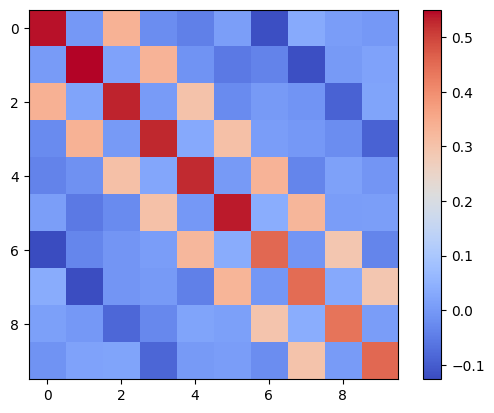

In [23]:
#Displaying the weight matrix of semi equivariant linear autoencoder
from scipy.linalg import block_diag
block_diag_matrix = block_diag(WW0,WW1,WW2,WW3,WW4,WW5,WW6,WW7,WW8,WW9,WW10,WW11,WW12,WW13,WW14)

W_sol = Q @ block_diag_matrix.T @ Q.T
W_s = block_diag_matrix
plt.imshow(W_s[40:50,40:50], cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show


equi_1: 0.006962712135241708  nonequi_1: 0.00559745030477643
equi_2: 0.008198430555855556  nonequi_2: 0.008753752335906029
equi_3: 0.01376842869545109  nonequi_3: 0.011730540543794632
equi_4: 0.0028649264787920558  nonequi_4: 0.002333997515961528
equi_5: 0.002648456336179163  nonequi_5: 0.0015165815129876137
equi_6: 0.006625056638744175  nonequi_6: 0.005365877877920866
equi_7: 0.008763178512284888  nonequi_7: 0.006318160332739353
equi_8: 0.01150235744127154  nonequi_8: 0.009829802438616753
equi_9: 0.008623632543919544  nonequi_9: 0.006515370216220617
equi_10: 0.008767057251977928  nonequi_10: 0.007688071113079786


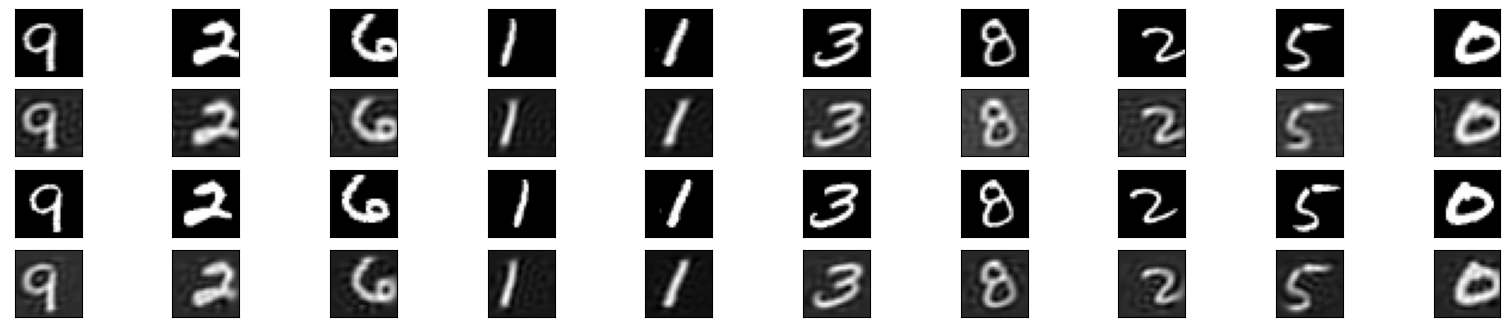

In [24]:
#Output of semi equivariant linear autoencoder with MSE.
import numpy as np
v = x_train_shifted_flat[10]
v =   W_sol @v  
# Assuming v is your flattened vector for a single black and white image
plt.figure(figsize=(20, 4))
for i, index in enumerate(random_indices):
    
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(x_test_shifted_flat[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(index)
    v = x_test_shifted_flat[index]
    v =   W_sol @v 
    ax = plt.subplot(4, 10, i + 11)
    plt.imshow(v.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 10, i + 21)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 10, i + 31)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(np.mean(np.square(x_test_shifted_flat[index]-v)))
    #print(np.mean(np.square(x_test_shifted_flat[index]-encoded_imgs[i])))
    result_a = np.mean(np.square(x_test_shifted_flat[index] - v))
    result_b = np.mean(np.square(x_test_shifted_flat[index] - encoded_imgs[i]))
    # Print the results next to each other
    print(f'equi_{i+1}: {result_a}  nonequi_{i+1}: {result_b}')
plt.show()

In [25]:
#Error compution for semi-equivariant and non-equivariant network.
import numpy as np
result_equi=[]
result_nonequi=[]
for i in range(300):
    
    random_indices1111 = np.random.choice(x_test_shifted_flat.shape[0], 300, replace=False)
    v = x_test_shifted_flat[random_indices1111[i]]
    v =  W_sol @v 
    result_equi.append(np.mean(np.square(x_test_shifted_flat[random_indices1111[i]] - v)))
    encoded_imgs1111 = autoencoder.predict(x_test_shifted_flat[random_indices1111])
    result_nonequi.append(np.mean(np.square(x_test_shifted_flat[random_indices1111[i]] - encoded_imgs1111[i])))

print(np.mean(result_equi))
print(np.mean(result_nonequi))

 1/10 [==>...........................] - ETA: 0s

10/10 [==============================] - 0s 3ms/step
0.007618165892832033
0.0057233484


In [26]:
#Applyig realization format to semi-equivariant network to make it fully equivariant under horizantal shift (see the paper).
WWW1=WW1.copy()
for i in range(28):
    for j in range(28):
       WWW1[2*i,2*j] = (WW1[2*i,2*j]+WW1[2*i+1,2*j+1])/2
       WWW1[2*i+1,2*j+1] = (WW1[2*i,2*j]+WW1[2*i+1,2*j+1])/2
       WWW1[2*i,2*j+1] = -(WW1[2*i+1,2*j]-WW1[2*i,2*j+1])/2
       WWW1[2*i+1,2*j] = (WW1[2*i+1,2*j]-WW1[2*i,2*j+1])/2
 
W1_shrink = WWW1[::2, :]
rank = 10
U, S, Vt = np.linalg.svd(W1_shrink, full_matrices=False)
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
Vt_ranked = Vt[:rank, :]

# Reconstruct the matrix with rank 10
W1_ranked = np.dot(U_ranked, np.dot(S_ranked, Vt_ranked))
W1_expand = np.zeros((56,56))
for i in range(56):
    for j in range(56):
        if i%2==0:
           W1_expand[i,j] = W1_ranked[int(i/2),j]
        else:
            if j%2==0:
                W1_expand[i,j] = -W1_ranked[int(i/2),j+1]
            else:
                W1_expand[i,j] = W1_ranked[int(i/2),j-1]
###############################################################################

WWW2=WW2.copy()
for i in range(28):
    for j in range(28):
       WWW2[2*i,2*j] = (WW2[2*i,2*j]+WW2[2*i+1,2*j+1])/2
       WWW2[2*i+1,2*j+1] = (WW2[2*i,2*j]+WW2[2*i+1,2*j+1])/2
       WWW2[2*i,2*j+1] = -(WW2[2*i+1,2*j]-WW2[2*i,2*j+1])/2
       WWW2[2*i+1,2*j] = (WW2[2*i+1,2*j]-WW2[2*i,2*j+1])/2
 
W2_shrink = WWW2[::2, :]
rank = 9
U, S, Vt = np.linalg.svd(W2_shrink, full_matrices=False)
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
Vt_ranked = Vt[:rank, :]
W2_ranked = np.dot(U_ranked, np.dot(S_ranked, Vt_ranked))
W2_expand = np.zeros((56,56))
for i in range(56):
    for j in range(56):
        if i%2==0:
           W2_expand[i,j] = W2_ranked[int(i/2),j]
        else:
            if j%2==0:
                W2_expand[i,j] = -W2_ranked[int(i/2),j+1]
            else:
                W2_expand[i,j] = W2_ranked[int(i/2),j-1]
###############################################################################
WWW3=WW3.copy()
for i in range(28):
    for j in range(28):
       WWW3[2*i,2*j] = (WW3[2*i,2*j]+WW3[2*i+1,2*j+1])/2
       WWW3[2*i+1,2*j+1] = (WW3[2*i,2*j]+WW3[2*i+1,2*j+1])/2
       WWW3[2*i,2*j+1] = -(WW3[2*i+1,2*j]-WW3[2*i,2*j+1])/2
       WWW3[2*i+1,2*j] = (WW3[2*i+1,2*j]-WW3[2*i,2*j+1])/2
 
W3_shrink = WWW3[::2, :]
rank = 8
U, S, Vt = np.linalg.svd(W3_shrink, full_matrices=False)
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
Vt_ranked = Vt[:rank, :]
W3_ranked = np.dot(U_ranked, np.dot(S_ranked, Vt_ranked))
W3_expand = np.zeros((56,56))
for i in range(56):
    for j in range(56):
        if i%2==0:
           W3_expand[i,j] = W3_ranked[int(i/2),j]
        else:
            if j%2==0:
                W3_expand[i,j] = -W3_ranked[int(i/2),j+1]
            else:
                W3_expand[i,j] = W3_ranked[int(i/2),j-1]
###############################################################################
WWW4=WW4.copy()
for i in range(28):
    for j in range(28):
       WWW4[2*i,2*j] = (WW4[2*i,2*j]+WW4[2*i+1,2*j+1])/2
       WWW4[2*i+1,2*j+1] = (WW4[2*i,2*j]+WW4[2*i+1,2*j+1])/2
       WWW4[2*i,2*j+1] = -(WW4[2*i+1,2*j]-WW4[2*i,2*j+1])/2
       WWW4[2*i+1,2*j] = (WW4[2*i+1,2*j]-WW4[2*i,2*j+1])/2
 
W4_shrink = WWW4[::2, :]
rank = 7
U, S, Vt = np.linalg.svd(W4_shrink, full_matrices=False)
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
Vt_ranked = Vt[:rank, :]
W4_ranked = np.dot(U_ranked, np.dot(S_ranked, Vt_ranked))
W4_expand = np.zeros((56,56))
for i in range(56):
    for j in range(56):
        if i%2==0:
           W4_expand[i,j] = W4_ranked[int(i/2),j]
        else:
            if j%2==0:
                W4_expand[i,j] = -W4_ranked[int(i/2),j+1]
            else:
                W4_expand[i,j] = W4_ranked[int(i/2),j-1]
###############################################################################
WWW5=WW5.copy()
for i in range(28):
    for j in range(28):
       WWW5[2*i,2*j] = (WW5[2*i,2*j]+WW5[2*i+1,2*j+1])/2
       WWW5[2*i+1,2*j+1] = (WW5[2*i,2*j]+WW5[2*i+1,2*j+1])/2
       WWW5[2*i,2*j+1] = -(WW5[2*i+1,2*j]-WW5[2*i,2*j+1])/2
       WWW5[2*i+1,2*j] = (WW5[2*i+1,2*j]-WW5[2*i,2*j+1])/2
 
W5_shrink = WWW5[::2, :]
rank = 5
U, S, Vt = np.linalg.svd(W5_shrink, full_matrices=False)
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
Vt_ranked = Vt[:rank, :]
W5_ranked = np.dot(U_ranked, np.dot(S_ranked, Vt_ranked))
W5_expand = np.zeros((56,56))
for i in range(56):
    for j in range(56):
        if i%2==0:
           W5_expand[i,j] = W5_ranked[int(i/2),j]
        else:
            if j%2==0:
                W5_expand[i,j] = -W5_ranked[int(i/2),j+1]
            else:
                W5_expand[i,j] = W5_ranked[int(i/2),j-1]
###############################################################################
WWW6=WW6.copy()
for i in range(28):
    for j in range(28):
       WWW6[2*i,2*j] = (WW6[2*i,2*j]+WW6[2*i+1,2*j+1])/2
       WWW6[2*i+1,2*j+1] = (WW6[2*i,2*j]+WW6[2*i+1,2*j+1])/2
       WWW6[2*i,2*j+1] = -(WW6[2*i+1,2*j]-WW6[2*i,2*j+1])/2
       WWW6[2*i+1,2*j] = (WW6[2*i+1,2*j]-WW6[2*i,2*j+1])/2
 
W6_shrink = WWW6[::2, :]
rank = 3
U, S, Vt = np.linalg.svd(W6_shrink, full_matrices=False)
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
Vt_ranked = Vt[:rank, :]
W6_ranked = np.dot(U_ranked, np.dot(S_ranked, Vt_ranked))
W6_expand = np.zeros((56,56))
for i in range(56):
    for j in range(56):
        if i%2==0:
           W6_expand[i,j] = W6_ranked[int(i/2),j]
        else:
            if j%2==0:
                W6_expand[i,j] = -W6_ranked[int(i/2),j+1]
            else:
                W6_expand[i,j] = W6_ranked[int(i/2),j-1]
###############################################################################
WWW7=WW7.copy()
for i in range(28):
    for j in range(28):
       WWW7[2*i,2*j] = (WW7[2*i,2*j]+WW7[2*i+1,2*j+1])/2
       WWW7[2*i+1,2*j+1] = (WW7[2*i,2*j]+WW7[2*i+1,2*j+1])/2
       WWW7[2*i,2*j+1] = -(WW7[2*i+1,2*j]-WW7[2*i,2*j+1])/2
       WWW7[2*i+1,2*j] = (WW7[2*i+1,2*j]-WW7[2*i,2*j+1])/2
 
W7_shrink = WWW7[::2, :]
rank = 1
U, S, Vt = np.linalg.svd(W7_shrink, full_matrices=False)
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
Vt_ranked = Vt[:rank, :]
W7_ranked = np.dot(U_ranked, np.dot(S_ranked, Vt_ranked))
W7_expand = np.zeros((56,56))
for i in range(56):
    for j in range(56):
        if i%2==0:
           W7_expand[i,j] = W7_ranked[int(i/2),j]
        else:
            if j%2==0:
                W7_expand[i,j] = -W7_ranked[int(i/2),j+1]
            else:
                W7_expand[i,j] = W7_ranked[int(i/2),j-1]
###############################################################################

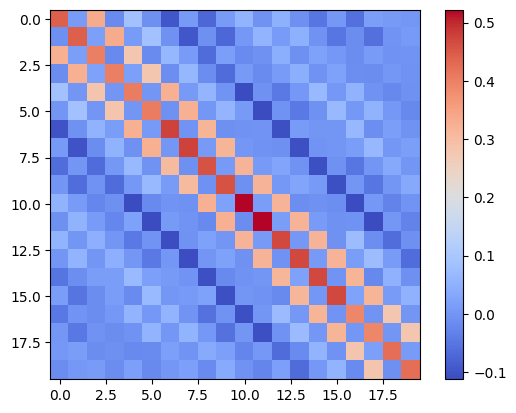

In [27]:
#A realization block.
plt.imshow(W1_expand[20:40, 20:40], cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

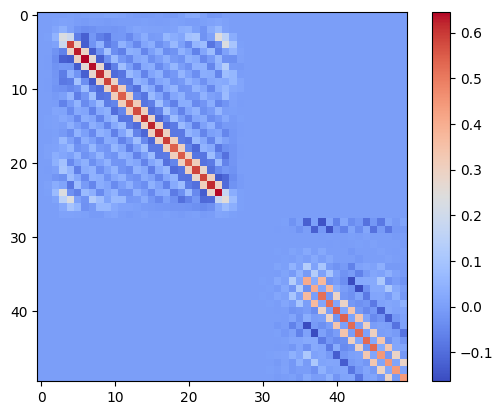

In [29]:
#Displaying the weight matrix for trained linear autoencoder which is equivariant under horizental shift
block_diag_matrix_equi = block_diag(WW0,W1_expand,W2_expand,W3_expand,W4_expand,W5_expand,W6_expand,W7_expand,WW8,WW9,WW10,WW11,WW12,WW13,WW14)
W_sol_equi = Q @ block_diag_matrix_equi.T @ Q.T
W_s_equi = block_diag_matrix_equi
plt.imshow(W_s_equi[0:50,0:50], cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show


equi_1: 0.00772157948349305  nonequi_1: 0.00559745030477643
equi_2: 0.008536272479843945  nonequi_2: 0.008753752335906029
equi_3: 0.01421819680304732  nonequi_3: 0.011730540543794632
equi_4: 0.003210950348879558  nonequi_4: 0.002333997515961528
equi_5: 0.0028270572574302056  nonequi_5: 0.0015165815129876137
equi_6: 0.007178373300580753  nonequi_6: 0.005365877877920866
equi_7: 0.009779931905456977  nonequi_7: 0.006318160332739353
equi_8: 0.01247955339312161  nonequi_8: 0.009829802438616753
equi_9: 0.009204127312877992  nonequi_9: 0.006515370216220617
equi_10: 0.009238783281277646  nonequi_10: 0.007688071113079786


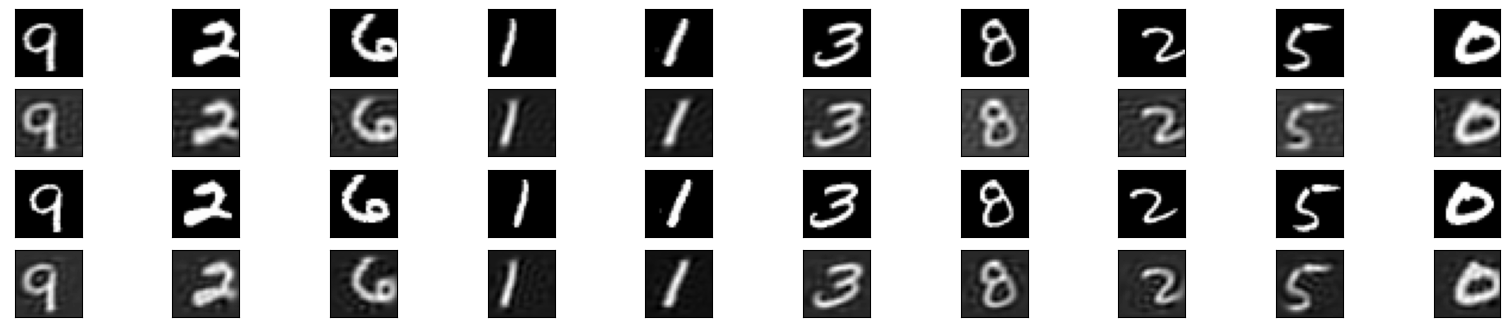

In [31]:
#Output of linear equivariant autoencoder and linear autoencdoer.
import numpy as np
v = x_train_shifted_flat[10]
v =   W_sol_equi @v  
np.random.seed(44)
random_indices = np.random.choice(x_test_shifted_flat.shape[0], 10, replace=False)

plt.figure(figsize=(20, 4))
for i, index in enumerate(random_indices):
    
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(x_test_shifted_flat[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(index)
    v = x_test_shifted_flat[index]
    v =   W_sol_equi @v 
    ax = plt.subplot(4, 10, i + 11)
    plt.imshow(v.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 10, i + 21)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 10, i + 31)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(np.mean(np.square(x_test_shifted_flat[index]-v)))
    #print(np.mean(np.square(x_test_shifted_flat[index]-encoded_imgs[i])))
    result_a = np.mean(np.square(x_test_shifted_flat[index] - v))
    result_b = np.mean(np.square(x_test_shifted_flat[index] - encoded_imgs[i]))

    # Print the results next to each other
    print(f'equi_{i+1}: {result_a}  nonequi_{i+1}: {result_b}')
plt.show()
#Error for fully equivariant and non-equivariant autoencdoer is displayed.
#In the picture, the first row is randomly shifted data without encoding, second row is the output of equivariant linear autoencdoer
#Third row is the original data without random shift and forth row is the output of non-equivariant linear autoencoder.

In [32]:
#Error computation of linear equivariant autoencdoer
import numpy as np
result_equi=[]
result_nonequi=[]
for i in range(300):
    
    random_indices1111 = np.random.choice(x_test_shifted_flat.shape[0], 300, replace=False)
    v = x_test_shifted_flat[random_indices1111[i]]
    v =  W_sol_equi @v 
    result_equi.append(np.mean(np.square(x_test_shifted_flat[random_indices1111[i]] - v)))
    encoded_imgs1111 = autoencoder.predict(x_test_shifted_flat[random_indices1111])
    result_nonequi.append(np.mean(np.square(x_test_shifted_flat[random_indices1111[i]] - encoded_imgs1111[i])))


10/10 [==============================] - 0s 3ms/step


In [33]:
#final error for equi and non-equi linear autoencoder
print(np.mean(result_equi))
print(np.mean(result_nonequi))


0.00815997939763123
0.005588455


In [33]:
#Computation of the number of different equivariant architecture using dynamic programming.
def count_solutions(y, n, constraints):
    m = len(y)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    dp[0][0] = 1

    for i in range(1, m + 1):
        for j in range(n + 1):
            k = 0
            while k * y[i - 1] <= j and k <= constraints[1]:
                dp[i][j] += dp[i - 1][j - k * y[i - 1]]
                k += 1
    return dp[m][n]

def main():
    y = [1,2,2,2,2,2,2,2,2,2,2,2,2,2,1] 
    n = 99
    constraints = (0, 28)  
    result = count_solutions(y, n, constraints)
    print(f"Number of real irreducible components: {result}")

if __name__ == "__main__":
    main()


Number of real irreducible components: 72425986088826
